In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch_geometric.nn import GCNConv

# Data loaded via the `collect_all_data` function in `get_data.py`

In [43]:
match_info = pd.read_csv("data/matches_info.csv")
possessions = pd.read_csv("data/possessions.csv")
run_features = pd.read_csv("data/run_features.csv")
tracking_data = pd.read_csv("data/tracking_data.csv")
player_to_team = pd.read_csv("data/player_team.csv").set_index("id")

merged = pd.merge(possessions,run_features,on=["match_id","possession_index"],how="outer",suffixes=("_possession","_run"))

merged["possession_lead_to_shot"] = (merged["possession_lead_to_shot"] | merged["lead_to_shot"])# Need to update wheter runs and possessions lead to shots on values that conflict
merged["possession_lead_to_goal"] = (merged["possession_lead_to_goal"] | merged["lead_to_goal"])


In [44]:
run_types_to_predict = ['run_ahead_of_the_ball','cross_receiver','behind']
runs_to_predict = merged[merged.event_subtype.isin(run_types_to_predict)]

In [45]:
tracking_frame_groups = {
    (mid, rid): df
    for (mid, rid), df in tracking_data.groupby(
        ["match_id", "run_id"]
    )
}

# Validating that we can build graphs for each run

In [46]:
def validate_run(run_row):
    runner_id = run_row["player_id"]
    match_id = run_row["match_id"]
    run_id = run_row["event_id"]

    frame_start = int(run_row["frame_start_run"])
    frame_end = int(run_row["frame_end_run"])

    tracking = tracking_frame_groups[(match_id, run_id)]

    lower_frame = max(frame_start-10,tracking["frame_id"].min())
    
    expected_frames = set(range(lower_frame, frame_end + 1))
    actual_frames = set(tracking["frame_id"].unique().tolist())

    if not expected_frames.issubset(actual_frames):
        return False
    
    runner_per_frame = (
        tracking
        .groupby("frame_id")["player"]
        .apply(lambda players: runner_id in players.values)
    )
    return runner_per_frame.all()
runs_to_predict = runs_to_predict[runs_to_predict.apply(validate_run,axis=1)]

# Build Graph

In [47]:
def build_graph_from_frame(
    frame_df,
    runner_player_id,
    player_to_team,
    R=15.0
):
    """
    frame_df: rows = players at ONE frame_id
    """
    frame_df = frame_df.sort_values("player").reset_index(drop=True)

    player_ids = frame_df["player"].values
    Np = len(player_ids)

    #player nodes

    player_feats = torch.tensor(
        frame_df[[
            "x", "y",
            "dx", "dy",
            "speed",
            "acceleration"
        ]].values,
        dtype=torch.float
    )

    team_ids = torch.tensor(
        player_to_team.loc[player_ids, "team_id"].values,
        dtype=torch.long
    )

    # runner flag for players
    is_runner_player = torch.tensor(
        (player_ids == runner_player_id).astype(float),
        dtype=torch.float
    ).unsqueeze(1)

    is_runner = torch.cat(
        [is_runner_player, torch.zeros(1, 1)],
        dim=0
    )

    is_ball = torch.zeros(Np + 1, dtype=torch.bool)

    #ball node

    ball_feats = torch.tensor(
        [[
            frame_df["ball_x"].iloc[0],
            frame_df["ball_y"].iloc[0],
            frame_df["ball_dx"].iloc[0],
            frame_df["ball_dy"].iloc[0],
            frame_df["ball_speed"].iloc[0],
            frame_df["ball_acceleration"].iloc[0],
        ]],
        dtype=torch.float
    )

    #node features

    x = torch.cat([
        player_feats,
        ball_feats
    ], dim=0)

    is_ball[-1] = True
    is_ball_feat = is_ball.float().unsqueeze(1)

    team_ids = torch.cat([
        team_ids,
        torch.tensor([-1])
    ])

    x = torch.cat([
        x,
        is_runner,
        is_ball_feat
    ], dim=1)

    #edges between players

    pos = x[:, :2]
    vel = x[:, 2:4]
    N = pos.size(0)

    edge_index = []
    edge_attr = []

    for i in range(N):
        for j in range(N):
            if i == j:
                continue

            dist = torch.norm(pos[i] - pos[j])

            if (dist < R) or is_ball[i] or is_ball[j]:

                same_team = int(
                    (team_ids[i] == team_ids[j]) and
                    (team_ids[i] != -1)
                )

                ball_edge = int(is_ball[i] or is_ball[j])

                # relative velocity between players
                rel_v = vel[j] - vel[i]
                direction = (pos[j] - pos[i]) / (dist + 1e-6)
                rel_speed = torch.dot(rel_v, direction)

                edge_index.append([i, j])
                edge_attr.append([
                    dist.item(),
                    same_team,
                    ball_edge,
                    rel_speed.item()
                ])

    edge_index = torch.tensor(edge_index, dtype=torch.long).T
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    runner_idx = int(
        torch.where(
            torch.tensor(player_ids) == runner_player_id
        )[0].item()
    )

    return Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        runner_idx=torch.tensor(runner_idx, dtype=torch.long),
        team_ids=team_ids,
        is_ball=is_ball
    )
    

In [48]:
RUN_NUM = 0
RUN_FRAME = 2
run = runs_to_predict.iloc[RUN_NUM]
match_id = run["match_id"]
run_id = run["id"]
player = run["player_id"]

run_tracking = tracking_data[(tracking_data.run_id == run_id) & (tracking_data.match_id == match_id)]
run_tracking["timestamp"] = pd.to_timedelta(run_tracking["timestamp"]).dt.total_seconds()
frame_num = run_tracking["frame_id"].sort_values().iloc[0] + RUN_FRAME
frame_df = run_tracking[run_tracking["frame_id"]==frame_num]


build_graph_from_frame(frame_df=frame_df,runner_player_id=player,player_to_team=player_to_team)

C:\Users\zcoch\AppData\Local\Temp\ipykernel_48992\1989320963.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_tracking["timestamp"] = pd.to_timedelta(run_tracking["timestamp"]).dt.total_seconds()


Data(x=[23, 8], edge_index=[2, 140], edge_attr=[140, 4], runner_idx=21, team_ids=[23], is_ball=[23])

# Temporal Dataset class

In [49]:
class TemporalRunnerDataset(Dataset):
    def __init__(self, tracking_df, run_features, player_to_team, samples, T=10, horizon=1, R=15.0):
        self.df = tracking_df
        self.run_features = run_features
        self.player_to_team = player_to_team
        self.samples = samples
        self.T = T
        self.horizon = horizon
        self.R = R

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        match_id,run_id, frame_t, runner_id = self.samples[idx]

        graphs = []

        for t in range(frame_t - self.T + 1, frame_t + 1):

            frame_df = self.df[(match_id,run_id)]
            frame_df = frame_df[frame_df["frame_id"]==t]
            try:
                g = build_graph_from_frame(
                    frame_df=frame_df,
                    runner_player_id=runner_id,
                    player_to_team=self.player_to_team,
                    R=self.R
                )
            except:
                print(match_id,run_id,t,runner_id)
                print(frame_df.to_markdown())
                raise()

            graphs.append(g)
            
        graphs_batch = Batch.from_data_list(graphs)

        #target is to predict change in x and y
        future = self.df[(match_id,run_id)]
        future = future[(future["frame_id"]==frame_t+self.horizon) & (future["player"] == runner_id)]
        
        target = torch.tensor(
            future[["dx", "dy"]].values.squeeze(),
            dtype=torch.float
        )
        
        lead_to_shot_val = self.run_features.loc[self.run_features['id'] == run_id, 'possession_lead_to_shot'].values
        if len(lead_to_shot_val) == 0:
            shot_label = torch.tensor(0.0) 
        else:
            shot_label = torch.tensor(float(lead_to_shot_val[0]))

        return graphs_batch, target, shot_label

def build_samples_from_runs(run_features, T, horizon):
    samples = []

    for _, run in tqdm(run_features.iterrows()):
        match_id = run["match_id"]
        run_id = run["event_id"]
        runner_id = run["player_id"]

        frame_start = int(run["frame_start_run"])
        frame_end = int(run["frame_end_run"])

        # earliest frame we can use (need T past frames)
        frame_df_min = tracking_frame_groups[(match_id,run_id)]["frame_id"].min()
        t_min = frame_start
        t_max = frame_end - horizon

        if t_min > t_max:
            continue 
        if t_min - T < frame_df_min:
            t_min = frame_df_min + T
            
        for t in range(t_min, t_max + 1):
            samples.append(
                (match_id,run_id, t, runner_id)
            )

    return samples


In [50]:
T = 10
horizon = 1

samples = build_samples_from_runs(runs_to_predict, T, horizon)

1920it [00:00, 9221.90it/s]


In [51]:
dataset = TemporalRunnerDataset(
    tracking_df=tracking_frame_groups,
    run_features=runs_to_predict,
    player_to_team=player_to_team,
    samples=samples,
    T=10,
    horizon=1,
    R=15.0
)
dataset

# Temporal GNN

In [11]:
class TemporalRunnerGNN(nn.Module):
    def __init__(self, node_feat_dim, gnn_hidden_dim, rnn_hidden_dim):
        super().__init__()

        self.gnn1 = GCNConv(node_feat_dim, gnn_hidden_dim)
        self.gnn2 = GCNConv(gnn_hidden_dim, gnn_hidden_dim)

        self.rnn = nn.GRU(
            input_size=gnn_hidden_dim,
            hidden_size=rnn_hidden_dim,
            batch_first=True
        )

        self.pos_head = nn.Linear(rnn_hidden_dim, 2)
        self.shot_head = nn.Linear(rnn_hidden_dim, 1)

    def forward(self, graphs_batch):
        """
        graphs_batch: PyG Batch containing T graphs (time steps)
        """
        device = next(self.parameters()).device
        graphs_batch = graphs_batch.to(device)

        x, edge_index = graphs_batch.x, graphs_batch.edge_index

        # ---- GNN ----
        x = F.relu(self.gnn1(x, edge_index))
        x = F.relu(self.gnn2(x, edge_index))

        batch_vec = graphs_batch.batch 
        runner_idx = graphs_batch.runner_idx

        T = runner_idx.size(0)
        runner_embeds = []

        for t in range(T):
            node_mask = (batch_vec == t)
            node_indices = node_mask.nonzero(as_tuple=False).view(-1)

            global_runner_idx = node_indices[runner_idx[t]]
            runner_embeds.append(x[global_runner_idx])

        runner_embeds = torch.stack(runner_embeds).unsqueeze(0)

        out, _ = self.rnn(runner_embeds)
        last_out = out[:, -1, :] 

        pred_pos = self.pos_head(last_out).squeeze(0)
        pred_shot = self.shot_head(last_out).squeeze(0) 

        return pred_pos, pred_shot


# Training Loop

In [30]:
alpha = 1.0  # weight for shot loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TemporalRunnerGNN(node_feat_dim=8, gnn_hidden_dim=64, rnn_hidden_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

dataloader = GeoDataLoader(dataset, batch_size=1, shuffle=True)
num_epochs = 10
model.train()

# percentage = 0.01
# total_batches = len(dataloader)
# num_batches = int(total_batches * percentage)

for epoch in range(num_epochs):
    total_loss = 0

    for graphs, target, shot_label in tqdm(dataloader): #batch_idx, () in enumerate(dataloader)
        # print(batch_idx/num_batches)
        # if batch_idx >= num_batches:
        #     break
        target = target.to(device).squeeze(0)
        shot_label = shot_label.to(device)

        optimizer.zero_grad()

        pred_pos, pred_shot = model(graphs)
        
        assert pred_pos.shape == target.shape
        assert pred_shot.shape == shot_label.shape
        
        weight = shot_label + 0.1 
        
        loss_pos = weight * F.mse_loss(pred_pos, target)
        loss_shot = F.binary_cross_entropy_with_logits(pred_shot.view(1),shot_label.view(1))
        loss = loss_pos + alpha * loss_shot
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: {total_loss / len(dataloader):.4f}")

torch.save(model.state_dict(), "temporal_runner_gnn.pth")


100%|██████████| 51772/51772 [3:08:35<00:00,  4.58it/s]  


Epoch 1: 0.5499


100%|██████████| 51772/51772 [3:21:04<00:00,  4.29it/s]  


Epoch 2: 0.5437


100%|██████████| 51772/51772 [3:21:56<00:00,  4.27it/s]  


Epoch 3: 0.5402


 41%|████▏     | 21408/51772 [1:21:25<1:55:28,  4.38it/s]


2011166 1_260 43151 957734.0
|         |   period_id | timestamp              |   frame_id |   ball_x |   ball_y |   ball_speed |   match_id |   run_id | run_active   |    id |   player |      x |      y |          d |        s |   dx |    dy |   dx_smooth |   dy_smooth |     ax |           ay |   ax_smooth |    ay_smooth |    speed |   speed_direction |   acceleration |   acc_direction |   ball_dx |   ball_dy |   ball_dx_smooth |   ball_dy_smooth |   ball_ax |   ball_ay |   ball_ax_smooth |   ball_ay_smooth |   ball_speed_direction |   ball_acceleration |   ball_acc_direction |
|--------:|------------:|:-----------------------|-----------:|---------:|---------:|-------------:|-----------:|---------:|:-------------|------:|---------:|-------:|-------:|-----------:|---------:|-----:|------:|------------:|------------:|-------:|-------------:|------------:|-------------:|---------:|------------------:|---------------:|----------------:|----------:|----------:|-----------------:|---------

TypeError: exceptions must derive from BaseException

In [52]:
model = TemporalRunnerGNN(node_feat_dim=8, gnn_hidden_dim=64, rnn_hidden_dim=32)
model.load_state_dict(torch.load("temporal_runner_gnn.pth"))
model.to(device)
model.eval() 

TemporalRunnerGNN(
  (gnn1): GCNConv(8, 64)
  (gnn2): GCNConv(64, 64)
  (rnn): GRU(64, 32, batch_first=True)
  (pos_head): Linear(in_features=32, out_features=2, bias=True)
  (shot_head): Linear(in_features=32, out_features=1, bias=True)
)

# Given tracking data and runner id predict optimal run path

In [206]:
model.eval()
T = 10
RUN_NUM = 8
run = runs_to_predict.iloc[RUN_NUM]
match_id = run["match_id"]
run_id = run["event_id"]
runner_id = run["player_id"]
team_id = run["team_id"]
run_start = int(run["frame_start_run"])
run_end = int(run["frame_end_run"])
run_tracking = tracking_frame_groups[(match_id,run_id)]
predicted_run_tracking = run_tracking.copy()
min_run_tracking_frame = run_tracking["frame_id"].min()
lower_frame = max(run_start-T,min_run_tracking_frame)
start_frame = lower_frame+T
frames_to_predict = range(start_frame,run_end+1)


for frame_to_predict in frames_to_predict:
    #create temporal graphs
    graphs = []
    for t in range(frame_to_predict - T + 1, frame_to_predict + 1):
        frame_df = predicted_run_tracking[predicted_run_tracking.frame_id==t]
        graph = build_graph_from_frame(frame_df=frame_df,runner_player_id=runner_id,player_to_team=player_to_team)
        graphs.append(graph)
    graphs_batch = Batch.from_data_list(graphs)
    graphs_batch = graphs_batch.to(device)
    #predict optimal runner direction
    with torch.no_grad():
        pred_pos, pred_shot_logit = model(graphs_batch)
    #probability of run up to this point being involved in shot
    pred_shot_prob = torch.sigmoid(pred_shot_logit)
    pred_dx, pred_dy = pred_pos
    pred_dx, pred_dy = float(pred_dx),float(pred_dy)
    print([pred_dx,pred_dy],pred_shot_prob)
        

    #update predicted runner positions for next frame prediction
    next_mask = (predicted_run_tracking.frame_id == frame_to_predict + 1) & (predicted_run_tracking.player == runner_id)
    curr_mask = (predicted_run_tracking.frame_id == frame_to_predict) & (predicted_run_tracking.player == runner_id)

    predicted_run_tracking.loc[next_mask,["dx","dy"]] = [pred_dx,pred_dy]
    predicted_run_tracking.loc[next_mask,["x","y"]] = (predicted_run_tracking.loc[curr_mask,["x","y"]] + np.array([pred_dx,pred_dy])).iloc[0].values
    FPS = 10
    #Recalculate the speed and acceleration components with new change in position
    predicted_run_tracking.loc[next_mask,"speed"] = np.sqrt(predicted_run_tracking.loc[next_mask,"dx"]**2 + predicted_run_tracking.loc[next_mask,"dy"] **2) * FPS
    predicted_run_tracking.loc[next_mask,"speed_direction"] = np.arctan2(predicted_run_tracking.loc[next_mask,"dy"],predicted_run_tracking.loc[next_mask,"dx"])
    predicted_run_tracking.loc[next_mask,"ax"] = np.array([predicted_run_tracking.loc[next_mask,"dx"].iloc[0]- predicted_run_tracking.loc[curr_mask,"dx"].iloc[0]])
    predicted_run_tracking.loc[next_mask,"ay"] = np.array([predicted_run_tracking.loc[next_mask,"dy"].iloc[0]- predicted_run_tracking.loc[curr_mask,"dy"].iloc[0]])
    vx = predicted_run_tracking.loc[next_mask,"dx"]
    vy = predicted_run_tracking.loc[next_mask,"dy"]
    speed_frame = np.sqrt(vx**2 + vy**2).iloc[0]
    eps = 1e-6
    vhat_x = vx / (speed_frame + eps)
    vhat_y = vy / (speed_frame + eps)
    predicted_run_tracking.loc[next_mask,"acceleration"] = (predicted_run_tracking.loc[next_mask,"ax"] * vhat_x + predicted_run_tracking.loc[next_mask,"ay"] * vhat_y)* FPS**2
    predicted_run_tracking.loc[next_mask,"acc_direction"] = np.arctan2(predicted_run_tracking.loc[next_mask,"ay"], predicted_run_tracking.loc[next_mask,"ax"])


[0.4309534430503845, 0.0756605789065361] tensor([0.2045])
[0.4316648244857788, 0.06671007722616196] tensor([0.2048])
[0.43361252546310425, 0.040337927639484406] tensor([0.2056])
[0.4381049871444702, 0.005994953215122223] tensor([0.2064])
[0.49817901849746704, 0.041717737913131714] tensor([0.1983])
[0.43531566858291626, 0.01798253506422043] tensor([0.2062])
[0.5095183253288269, 0.08432622998952866] tensor([0.1955])
[0.43443381786346436, 0.031395040452480316] tensor([0.2058])
[0.5093064904212952, 0.09710118919610977] tensor([0.1951])
[0.42959529161453247, 0.09360866993665695] tensor([0.2040])
[0.5045582056045532, 0.1610834300518036] tensor([0.1933])
[0.43855440616607666, 0.10218068212270737] tensor([0.2027])
[0.5027790069580078, 0.16127386689186096] tensor([0.1931])
[0.503888726234436, 0.16085946559906006] tensor([0.1934])
[0.5045284032821655, 0.16152256727218628] tensor([0.1933])
[0.5045424103736877, 0.16137102246284485] tensor([0.1933])
[0.5045316815376282, 0.16148149967193604] tensor(

# Plot Optimal Run Path

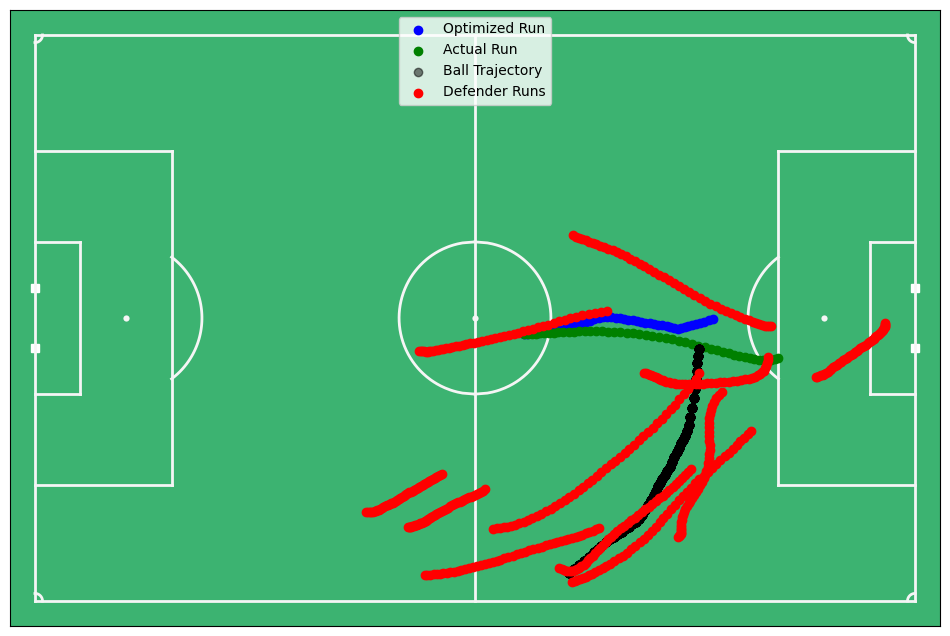

In [226]:
from visualization_tools import plot_soccer_pitch
import matplotlib.pyplot as plt
%matplotlib inline
plot_ball = True
plot_defense = True

fig, ax = plot_soccer_pitch()
pred_points = predicted_run_tracking[(predicted_run_tracking.run_active) & (predicted_run_tracking.player == runner_id)][["x","y"]]
pred_x = pred_points.values[:,0]
pred_y = pred_points.values[:,1]
plt.scatter(x=pred_x,y=pred_y,color="blue",label="Optimized Run")

active_run = run_tracking[run_tracking.run_active]
actual_points = active_run[(active_run.player == runner_id)][["x","y"]]
real_x = actual_points.values[:,0]
real_y = actual_points.values[:,1]
plt.scatter(x=real_x,y=real_y,color="green",label="Actual Run")

if plot_ball == True:
    ball_coords = active_run.iloc[:, ["ball" in col for col in active_run.columns]]
    ball_x = ball_coords.loc[:, "ball_x"].values
    ball_y = ball_coords.loc[:, "ball_y"].values
    ax.scatter(ball_x, ball_y, color="black", alpha=0.5, label="Ball Trajectory")

if plot_defense == True:
    defender_frames = active_run[(active_run["player"].apply(lambda id: player_to_team.loc[id])!=team_id).values[:,0]]
    def_x = defender_frames["x"]
    def_y = defender_frames["y"]
    plt.scatter(x=def_x,y=def_y,color="red",label = "Defender Runs")

plt.legend()
plt.show()

# Animate Optimal Run

In [ ]:
from visualization_tools import animate_run
%matplotlib tk

pred_runner = predicted_run_tracking[predicted_run_tracking.player==runner_id]
pred_runner["player"] = -1
run_tracking_with_pred = pd.concat([run_tracking,pred_runner])
animate_run(run=run,tracking_data=run_tracking_with_pred,player_to_team=player_to_team)